In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim import Adam

import Models
import Data
import utils

[nltk_data] Downloading package punkt to
[nltk_data]     /home/data/ysunbc/anaconda3/envs/yusen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [88]:
train_iter, test_iter, txt_field, label_field = Data.load_cls_dataset()

Number of vocab: 13190
Number of training samples: 50447
Number of testing samples: 4500
Example of training data:
 {'label': 'fear', 'source': 'tweets', 'sentence': ['sorry', 'friends', '-', 'i', "'m", 'swamped', 'with', 'deadlines', 'right', 'now', 'and', 'we', 'have', 'family', 'visiting', 'to', 'boot', '!', 'no', 'charades', 'for', 'me', '.']}

Example of testing data:
 {'label': 'fear', 'source': 'tweets', 'sentence': ['we', 'quite', 'like', 'worthing', 'its', 'a', 'relaxing', 'place', 'with', 'nice', 'coffee', 'shops', 'and', 'fresh', 'air..', 'and', 'not', 'too', 'many', 'oiks']}



In [10]:
class Record(object):
    def __init__(self):
        self.TRAIN_LOSS ={}
        self.TRAIN_True_Labels={}
        self.TRAIN_Predicted_Labels={}


        self.EVAL_LOSS={}
        self.EVAL_True_Labels={}
        self.EVAL_Predicted_Labels={}

        self.TRAIN_ACC_1 = {}
        self.EVAL_ACC_1 = {}
        
        self.TRAIN_ACC_3 = {}
        self.EVAL_ACC_3 = {}
        
        self.TRAIN_ACC_5 = {}
        self.EVAL_ACC_5 = {}
                
    def config_new_trial(self, model_name):
        self.TRAIN_LOSS[model_name] = [] 
        self.TRAIN_True_Labels[model_name] = [] 
        self.TRAIN_Predicted_Labels[model_name] = [] 
        
        self.EVAL_LOSS[model_name] = [] 
        self.EVAL_True_Labels[model_name] = [] 
        self.EVAL_Predicted_Labels[model_name] = [] 

        self.TRAIN_ACC_1[model_name] = [] 
        self.EVAL_ACC_1[model_name] = [] 
   
        self.TRAIN_ACC_3[model_name] = [] 
        self.EVAL_ACC_3[model_name] = [] 
        
        self.TRAIN_ACC_5[model_name] = [] 
        self.EVAL_ACC_5[model_name] = [] 
        
        
        
    def get_cls_acc(self, true, predict, k):
        correct = 0.0
        total = 0.0
        for i in range(len(true)):
            if true[i] in predict[i, :k]:
                correct+=1
            total+=1
        return correct/total
        
    def gen_acc(self, model_name):
        num_epoch = len(self.TRAIN_LOSS[model_name])
        for i in tqdm(range(num_epoch)):
            self.TRAIN_ACC_1[model_name].append(self.get_cls_acc(self.TRAIN_True_Labels[model_name][i], self.TRAIN_Predicted_Labels[model_name][i], 1))
            self.EVAL_ACC_1[model_name].append(self.get_cls_acc(self.EVAL_True_Labels[model_name][i], self.EVAL_Predicted_Labels[model_name][i], 1))
            
            self.TRAIN_ACC_3[model_name].append(self.get_cls_acc(self.TRAIN_True_Labels[model_name][i], self.TRAIN_Predicted_Labels[model_name][i], 3))
            self.EVAL_ACC_3[model_name].append(self.get_cls_acc(self.EVAL_True_Labels[model_name][i], self.EVAL_Predicted_Labels[model_name][i], 3))
            
            self.TRAIN_ACC_5[model_name].append(self.get_cls_acc(self.TRAIN_True_Labels[model_name][i], self.TRAIN_Predicted_Labels[model_name][i], 5))
            self.EVAL_ACC_5[model_name].append(self.get_cls_acc(self.EVAL_True_Labels[model_name][i], self.EVAL_Predicted_Labels[model_name][i], 5))


In [15]:
def train_cls(model, iterator, optimizer, criterion, device):
    
    model.train()
    epoch_loss = 0.0
    cumulated_num = 0
    true_labels = []
    predicted_labels = []
    
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        src, src_len = batch.sentence
        label = batch.label
        src, src_len, label = src.to(device), src_len, label.to(device)
 
        output = model.forward(src, src_len)
        loss = criterion(output, label)
        loss.backward()       

        predicted_labels.append(torch.topk(output.detach(), k=5,dim=-1)[1].cpu().numpy())
        true_labels.append(label.cpu().numpy())
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        cumulated_num += len(label)
        print('\r' + str(epoch_loss/cumulated_num), end='')
    
    return epoch_loss/cumulated_num, np.concatenate(true_labels), np.concatenate(predicted_labels, axis=0)


def evaluate_cls(model, iterator, criterion, device):
    
    model.eval()
    epoch_loss = 0.0
    cumulated_num = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            
            src, src_len = batch.sentence
            label = batch.label

            src, src_len, label = src.to(device), src_len, label.to(device)
            
            output = model.forward(src, src_len)
            loss = criterion(output, label)
            
            predicted_labels.append(torch.topk(output.detach(), k=5,dim=-1)[1].cpu().numpy())
            true_labels.append(label.cpu().numpy())

            epoch_loss += loss.item()
            cumulated_num += len(label)
            
            print('\r' + str(epoch_loss/cumulated_num), end='')
    
    return epoch_loss/cumulated_num, np.concatenate(true_labels), np.concatenate(predicted_labels, axis=0)



def run(model, op, EPOCH,  criterion, name, record):


    record.config_new_trial(name)
    for i in tqdm(range(EPOCH), desc='1sr loop'):

        loss, true_laebls, predicted_laebls = train_cls(gru, train_iter, gru_optimizer, criterion, device)
        record.TRAIN_LOSS[name].append(loss)
        record.TRAIN_True_Labels[name].append(true_laebls)
        record.TRAIN_Predicted_Labels[name].append(predicted_laebls)

        loss, true_laebls, predicted_laebls =  evaluate_cls(gru, test_iter, criterion, device)
        record.EVAL_LOSS[name].append(loss)
        record.EVAL_True_Labels[name].append(true_laebls)
        record.EVAL_Predicted_Labels[name].append(predicted_laebls)
        
    record.gen_acc(name)
    

In [24]:
train_full = pd.read_csv('./Dataset/emotion/train_full.csv')
weight = torch.FloatTensor(1/(np.array(list(train_full['label'].value_counts()))/min(list(train_full['label'].value_counts())))).to(device)
record = Record()
criterion = nn.CrossEntropyLoss(weight)
epoch = 30
VOCAB_SIZE = len(txt_field.vocab)
PAD_IDX = txt_field.vocab.stoi['<pad>']

## Try LSTM classifier on different settings

In [25]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.0002

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.1378324417273203425


In [26]:
EMB_DIM = 300
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.0002

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.1529607985284593454


In [27]:
EMB_DIM = 150
HID_DIM = 300
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.0002

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.1639032642311523563


In [28]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 2
lr = 0.0002

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.1477802017264896336


In [29]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.0001

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.094926526811387845


In [32]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.001

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.1842757784260643874


In [33]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.0005

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.17418535553084485657


In [34]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.1
NUM_LAYER = 1
lr = 0.00008

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

0.085060023572709825


In [35]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.2
NUM_LAYER = 1
lr = 0.0001

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr)

run(gru, gru_optimizer, epoch, criterion, model_name, record)

/home/data/ysunbc/anaconda3/envs/yusen/lib/python3.6/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


0.077226220276620666


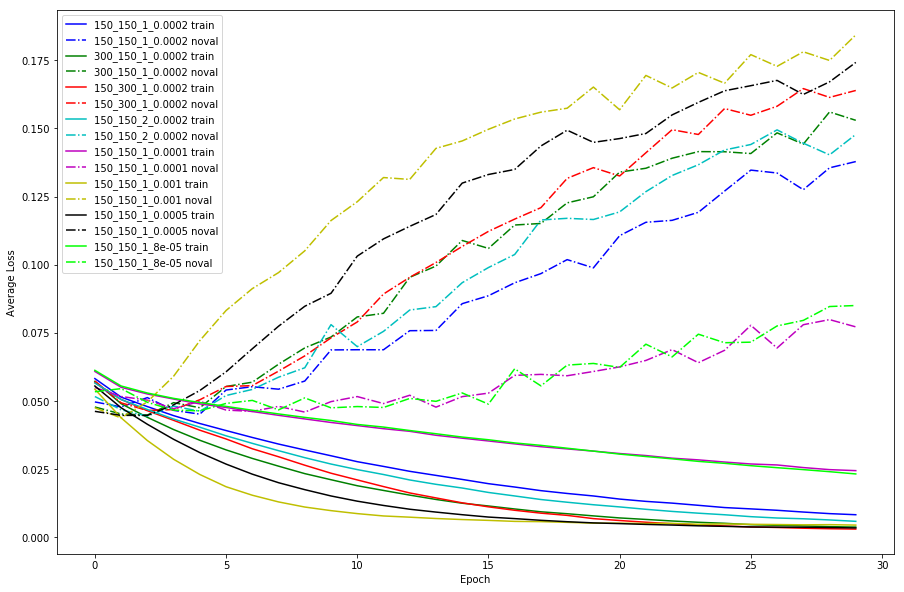

In [36]:
plot_set = list(record.TRAIN_LOSS.keys())
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'pink', 'skyblue', 'peru', 'orange', 'darkkahaki', 'plum' ]
plt.figure(figsize=(15,10))
for i in range(len(plot_set)):
    x = np.arange(len(record.TRAIN_LOSS[plot_set[i]]))
    plt.plot(x, record.TRAIN_LOSS[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_LOSS[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])

plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

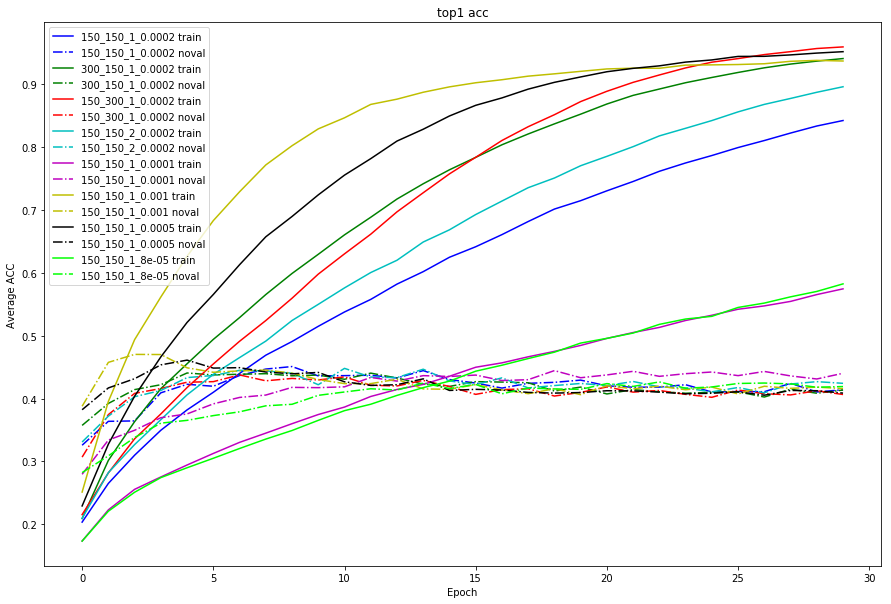

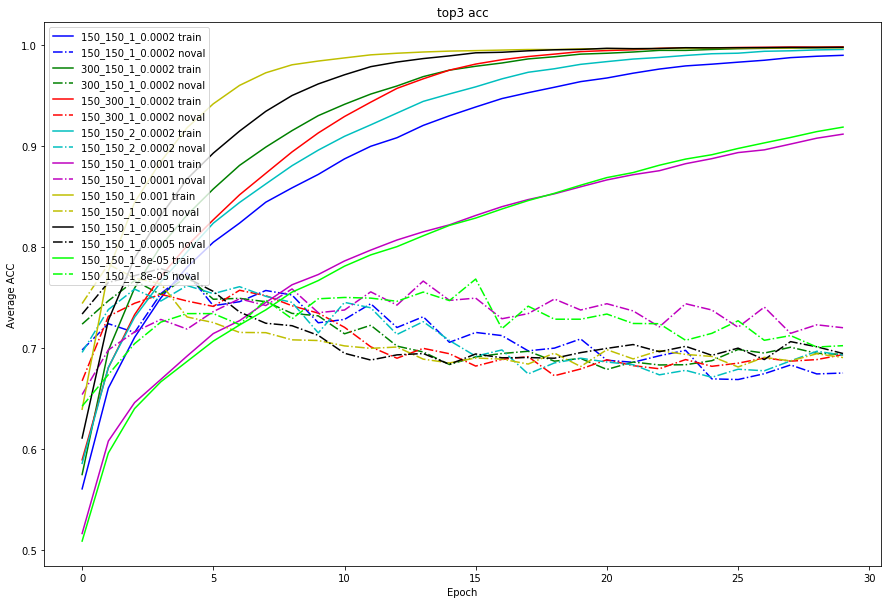

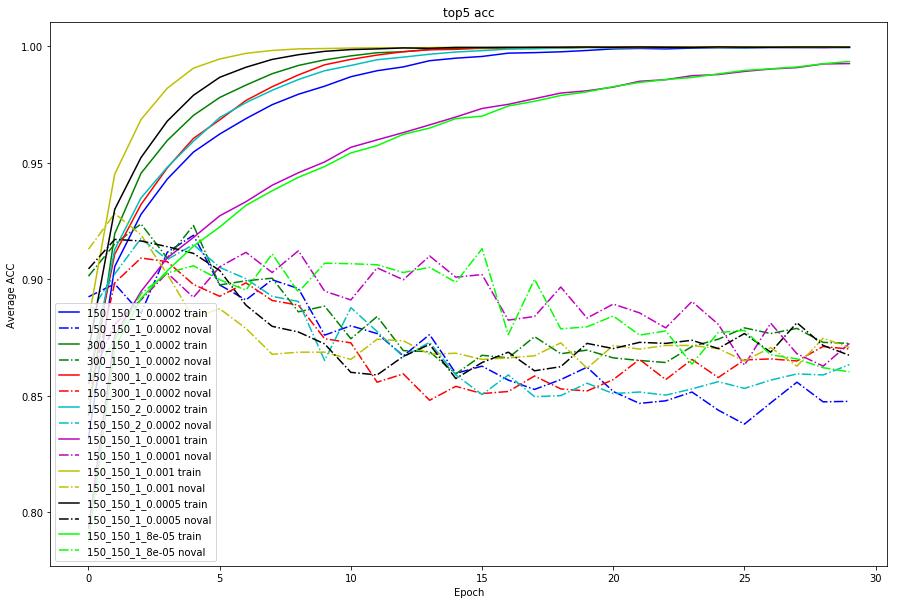

In [37]:

plot_set = list(record.TRAIN_ACC_1.keys())
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'pink', 'skyblue', 'peru', 'orange', 'darkkahaki', 'plum' ]
plt.figure(figsize=(15,10))
for i in range(len(plot_set)):
    x = np.arange(len(record.TRAIN_LOSS[plot_set[i]]))
    plt.plot(x, record.TRAIN_ACC_1[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_ACC_1[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])
plt.title('top1 acc')
plt.xlabel('Epoch')
plt.ylabel('Average ACC')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
for i in range(len(plot_set)):

    plt.plot(x, record.TRAIN_ACC_3[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_ACC_3[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])
plt.title('top3 acc')
plt.xlabel('Epoch')
plt.ylabel('Average ACC')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
for i in range(len(plot_set)):

    plt.plot(x, record.TRAIN_ACC_5[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_ACC_5[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])
plt.title('top5 acc')
plt.xlabel('Epoch')
plt.ylabel('Average ACC')
plt.legend()
plt.show()

In [85]:
model_name = '150_150_1_0.0001'
step = 23

In [86]:
record.EVAL_ACC_1[model_name][step], record.EVAL_ACC_3[model_name][step], record.EVAL_ACC_5[model_name][step]

(0.43955555555555553, 0.744, 0.8904444444444445)

array([[0.416, 0.144, 0.092, 0.062, 0.17 , 0.074, 0.022, 0.012, 0.008],
       [0.144, 0.438, 0.146, 0.096, 0.04 , 0.092, 0.014, 0.01 , 0.02 ],
       [0.148, 0.252, 0.38 , 0.082, 0.044, 0.058, 0.012, 0.016, 0.008],
       [0.062, 0.108, 0.114, 0.552, 0.018, 0.036, 0.042, 0.028, 0.04 ],
       [0.23 , 0.102, 0.058, 0.02 , 0.536, 0.052, 0.   , 0.002, 0.   ],
       [0.202, 0.224, 0.12 , 0.072, 0.098, 0.254, 0.024, 0.004, 0.002],
       [0.088, 0.074, 0.08 , 0.168, 0.006, 0.05 , 0.382, 0.096, 0.056],
       [0.032, 0.038, 0.04 , 0.104, 0.002, 0.004, 0.078, 0.44 , 0.262],
       [0.022, 0.028, 0.072, 0.096, 0.002, 0.   , 0.04 , 0.182, 0.558]])

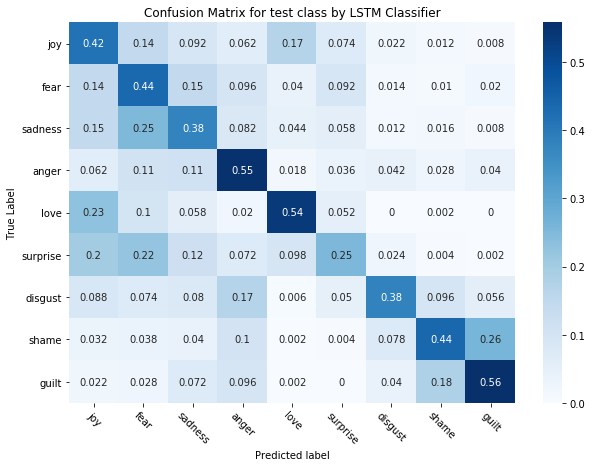

In [89]:

y_true = record.EVAL_True_Labels[model_name][step]
y_pred = [i[0] for i in record.EVAL_Predicted_Labels[model_name][step]]
utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for test class by LSTM Classifier', 'lstmclf_cm_test', list(label_field.vocab.stoi.keys()))


In [90]:
f1_score(y_true, y_pred, average='weighted')

0.4421912297427314

## train on support class only 

In [56]:
def run(trainiter, testiter, model, op, EPOCH,  criterion, name, record):


    record.config_new_trial(name)
    for i in tqdm(range(EPOCH), desc='1sr loop'):

        loss, true_laebls, predicted_laebls = train_cls(gru, trainiter, gru_optimizer, criterion, device)
        record.TRAIN_LOSS[name].append(loss)
        record.TRAIN_True_Labels[name].append(true_laebls)
        record.TRAIN_Predicted_Labels[name].append(predicted_laebls)

        loss, true_laebls, predicted_laebls =  evaluate_cls(gru, testiter, criterion, device)
        record.EVAL_LOSS[name].append(loss)
        record.EVAL_True_Labels[name].append(true_laebls)
        record.EVAL_Predicted_Labels[name].append(predicted_laebls)
        
    record.gen_acc(name)
    

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pickle
import numpy as np
import pandas as pd

from torchtext import *
from torchtext.data import *

import nltk
nltk.download('punkt')
from nltk import word_tokenize


def load_cls_sup_dataset():
    txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True)
    label_field = data.Field(sequential=False, unk_token=None)
    source_field = data.Field(sequential=False, unk_token=None)

    # make splits for data
    train, test= TabularDataset.splits(path='./Dataset/emotion', train='train_0.csv', test='support.csv',format='csv', 
                                      fields=[('label', label_field),('source', source_field), ('sentence', txt_field)], skip_header=True)
        
    # build the vocabulary on the training set only
    txt_field.build_vocab(train, min_freq=3)
    label_field.build_vocab(train)
    source_field.build_vocab(train)
    # make iterator for splits
    train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=32, sort_key=lambda x: len(x.sentence),sort_within_batch=True)
    
    print(f'Number of vocab: {len(txt_field.vocab)}')
    print(f'Number of training samples: {len(train.examples)}')
    print(f'Number of testing samples: {len(test.examples)}')

    print(f'Example of training data:\n {vars(train.examples[0])}\n')
    print(f'Example of testing data:\n {vars(test.examples[1])}\n')
    
    return train_iter, test_iter, txt_field, label_field


[nltk_data] Downloading package punkt to
[nltk_data]     /home/data/ysunbc/anaconda3/envs/yusen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
train0_iter, sup_iter, txt_field, label_field = load_cls_sup_dataset()

Number of vocab: 12324
Number of training samples: 45432
Number of testing samples: 2500
Example of training data:
 {'label': 'fear', 'source': 'tweets', 'sentence': ['sorry', 'friends', '-', 'i', "'m", 'swamped', 'with', 'deadlines', 'right', 'now', 'and', 'we', 'have', 'family', 'visiting', 'to', 'boot', '!', 'no', 'charades', 'for', 'me', '.']}

Example of testing data:
 {'label': 'fear', 'source': 'tweets', 'sentence': ['we', 'quite', 'like', 'worthing', 'its', 'a', 'relaxing', 'place', 'with', 'nice', 'coffee', 'shops', 'and', 'fresh', 'air..', 'and', 'not', 'too', 'many', 'oiks']}



In [61]:
EMB_DIM = 150
HID_DIM = 150
DROPOUT = 0.2
NUM_LAYER = 1
lr = 0.0001

gru = Models.LSTM_CLS(VOCAB_SIZE, EMB_DIM, HID_DIM, DROPOUT, PAD_IDX, NUM_LAYER).to(device)
gru_optimizer = Adam(gru.parameters(), lr=lr)
model_name = str(EMB_DIM) + '_' + str(HID_DIM) +'_' + str(NUM_LAYER) + '_'+ str(lr) + '_' + str('sup')

run(train0_iter, sup_iter , gru, gru_optimizer, epoch, criterion, model_name, record)

0.048596309208869936


In [96]:
model_name = '150_150_1_0.0001_sup'
step = 26

In [97]:
record.EVAL_ACC_1[model_name][step], record.EVAL_ACC_3[model_name][step], record.EVAL_ACC_5[model_name][step]

(0.55, 0.8732, 1.0)

0.5535429108044999

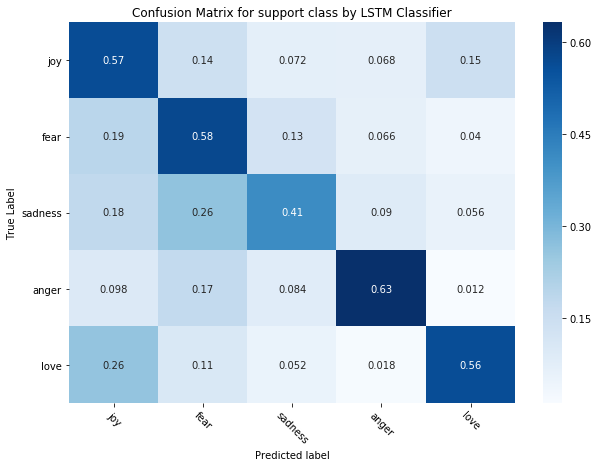

In [98]:
import utils
y_true = record.EVAL_True_Labels[model_name][step]
y_pred = [i[0] for i in record.EVAL_Predicted_Labels[model_name][step]]
m = utils.plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix for support class by LSTM Classifier', 'lstmclf_cm_sup', list(label_field.vocab.stoi.keys()))
f1_score(y_true, y_pred, average='weighted')

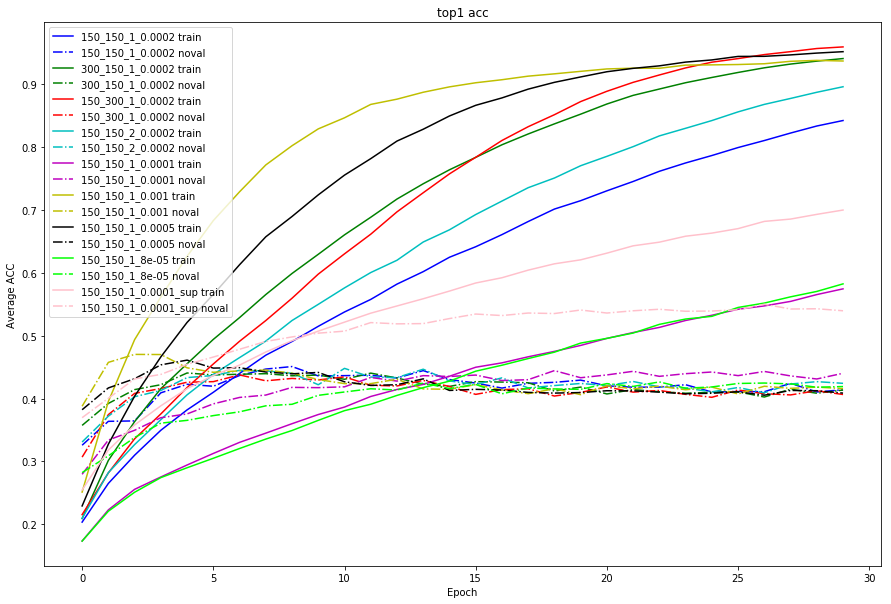

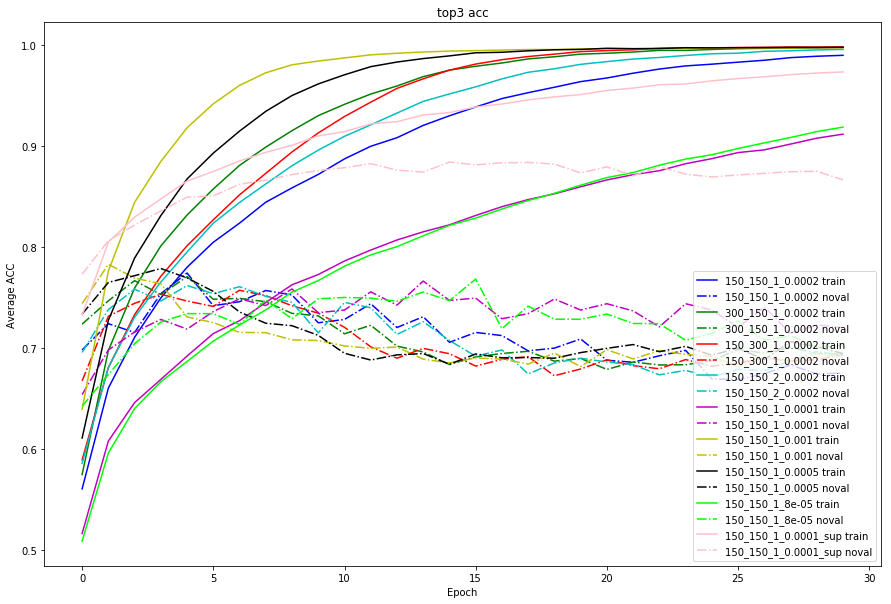

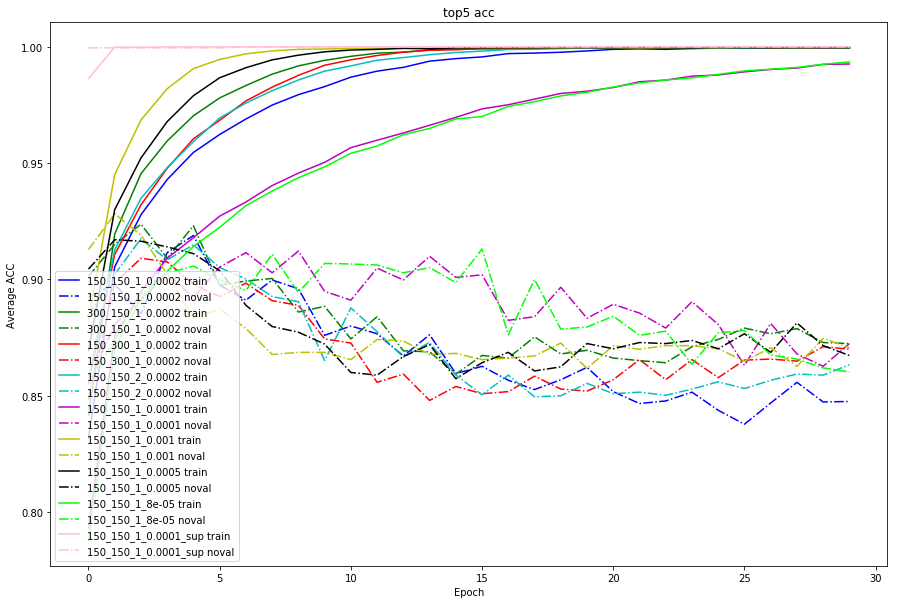

In [62]:

plot_set = list(record.TRAIN_ACC_1.keys())
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime', 'pink', 'skyblue', 'peru', 'orange', 'darkkahaki', 'plum' ]
plt.figure(figsize=(15,10))
for i in range(len(plot_set)):
    x = np.arange(len(record.TRAIN_LOSS[plot_set[i]]))
    plt.plot(x, record.TRAIN_ACC_1[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_ACC_1[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])
plt.title('top1 acc')
plt.xlabel('Epoch')
plt.ylabel('Average ACC')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
for i in range(len(plot_set)):

    plt.plot(x, record.TRAIN_ACC_3[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_ACC_3[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])
plt.title('top3 acc')
plt.xlabel('Epoch')
plt.ylabel('Average ACC')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
for i in range(len(plot_set)):

    plt.plot(x, record.TRAIN_ACC_5[plot_set[i]], label=str(plot_set[i])+' train' , c=color[i])
    plt.plot(x, record.EVAL_ACC_5[plot_set[i]], '-.', label=str(plot_set[i])+' noval', c=color[i])
plt.title('top5 acc')
plt.xlabel('Epoch')
plt.ylabel('Average ACC')
plt.legend()
plt.show()